# Exploratory Data Analysis (EDA) of Colorectal Cancer Bulk RNA-seq Atlas

## Introduction

This notebook performs an initial exploration of a colorectal cancer (CRC) bulk RNA-seq dataset that has been batch-corrected using `pycombat-seq`. 

The goals are to:
- Summarize the clinical and molecular cohort composition.
- Visualize distributions of key variables.
- Perform dimensionality reduction (PCA, UMAP) to reveal biological patterns or clusters.
- Generate hypotheses for downstream analyses based on observed data structure.

## Dataset

- **Gene expression matrix**: normalized and batch-corrected bulk RNA-seq data.
- **Clinical metadata**: patient and sample information including biopsy site, sample type, and clinical variables.

## Sample Sources

The samples used in this analysis are derived from three primary public resources:

- **GEO (Gene Expression Omnibus):** Individual experimental samples identified by GSM accessions.
- **GTEx (Genotype-Tissue Expression Project):** Healthy human tissue samples with IDs starting with "GTEX-".
- **TCGA (The Cancer Genome Atlas):** Cancer patient tumor and normal samples following the TCGA barcode format.

These diverse datasets provide a comprehensive overview of gene expression across healthy and diseased states.

## Tools & Libraries

We use Python libraries such as `pandas`, `matplotlib`, `seaborn`, and `plotly` for data processing and visualization.




## 1. Cohort Overview & Data Integrity

In this section, we perform an initial summary of the colorectal cancer (CRC) cohort and assess the integrity of the data. This includes:

- Summarizing the number of samples and patients
- Characterizing clinical variables such as biopsy site, sample type, age, and stage
- Checking for missing values and data completeness
- Verifying data types and value distributions

Understanding the structure and quality of the data is critical before proceeding to downstream analyses.


In [21]:
# importing libraries
import pandas as pd
import conorm
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.manifold import TSNE
import umap
import scanpy as sc
import anndata

# load the data
metadata_df = pd.read_csv('../data/CRC_atlas_clinical_data.csv', index_col=0)
expression_df = pd.read_csv('../data/CRC_atlas_gene_expression_data.csv', index_col=0)

In [22]:
# Display basic info
print("Clinical Data Overview:")
metadata_df.columns = metadata_df.columns.str.replace(' ', '_').str.lower()
display(metadata_df.shape)
display(metadata_df.info())
display(metadata_df.head())

Clinical Data Overview:


(2770, 34)

<class 'pandas.core.frame.DataFrame'>
Index: 2770 entries, GSM1133352 to TCGA-G5-6641-01A-11R-A32Z-07
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   age                   1776 non-null   float64
 1   age_category          1442 non-null   object 
 2   biopsy_subsite        1296 non-null   object 
 3   braf_mutation         619 non-null    object 
 4   biopsy_site           2770 non-null   object 
 5   biopsy_timepoint      1425 non-null   object 
 6   cms                   581 non-null    object 
 7   cancer_type           631 non-null    object 
 8   distal_vs_proximal    1662 non-null   object 
 9   donor_type            2770 non-null   object 
 10  egfr_mutated          515 non-null    object 
 11  grade                 79 non-null     object 
 12  her2_mutation         0 non-null      float64
 13  histological_subtype  1966 non-null   object 
 14  histological_type     1966 non-null   object

None

,age,age_category,biopsy_subsite,braf_mutation,biopsy_site,biopsy_timepoint,cms,cancer_type,distal_vs_proximal,donor_type,...,pfs_time,sample_type,gender,stage,tmb,tmb_group,tp53_mutation,therapy_response,therapy_type,tumor_type
GSM1133352,80.0,NaN,NaN,NaN,Colon,NaN,NaN,NaN,NaN,Tumor,...,NaN,Healthy sample,F,NaN,NaN,NaN,NaN,NaN,NaN,Solid tumor
GSM1133353,80.0,NaN,NaN,NaN,Colon,NaN,NaN,NaN,NaN,Tumor,...,NaN,Primary cancer,F,NaN,NaN,NaN,NaN,NaN,NaN,Solid tumor
GSM1133355,76.0,NaN,NaN,NaN,Colon,NaN,NaN,NaN,NaN,Tumor,...,NaN,Healthy sample,F,NaN,NaN,NaN,NaN,NaN,NaN,Solid tumor
GSM2042099,NaN,NaN,NaN,NaN,Colon,NaN,NaN,NaN,NaN,Tumor,...,NaN,Primary cancer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Solid tumor
GSM2042100,NaN,NaN,NaN,NaN,Colon,NaN,NaN,NaN,NaN,Tumor,...,NaN,Primary cancer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Solid tumor


In [3]:
print("\nExpression Data Overview:")
display(expression_df.shape)
display(expression_df.head())



Expression Data Overview:


(22723, 2770)

,GSM1133352,GSM1133353,GSM1133355,GSM2042099,GSM2042100,GSM2042101,GSM2042102,GSM2042124,GSM2042125,GSM2042126,...,TCGA-F5-6811-01A-11R-1830-07,TCGA-F5-6814-01A-31R-1928-07,TCGA-F5-6861-01A-11R-1928-07,TCGA-F5-6863-01A-11R-1928-07,TCGA-F5-6864-01A-11R-1928-07,TCGA-G5-6233-01A-11R-1736-07,TCGA-G5-6235-01A-11R-1736-07,TCGA-G5-6572-01A-11R-1830-07,TCGA-G5-6572-02A-12R-1830-07,TCGA-G5-6641-01A-11R-A32Z-07
A1BG,1.0,7.0,1.0,9.0,46.0,105.0,21.0,18.0,32.0,18.0,...,1.0,6.0,1.0,0.0,6.0,1.0,2.0,1.0,54.0,1.0
A1BG-AS1,1.0,3.0,0.0,17.0,44.0,95.0,28.0,16.0,27.0,21.0,...,9.0,11.0,3.0,13.0,27.0,9.0,2.0,7.0,10.0,1.0
A1CF,73.0,2.0,6.0,272.0,241.0,540.0,522.0,1384.0,2037.0,1468.0,...,1293.0,643.0,1561.0,894.0,1107.0,919.0,2665.0,2952.0,7298.0,1803.0
A2M,116.0,261.0,12.0,1229.0,6595.0,16567.0,3268.0,6031.0,7256.0,8621.0,...,26514.0,22071.0,13703.0,22004.0,53366.0,17415.0,3269.0,22187.0,143106.0,5077.0
A2M-AS1,3.0,3.0,1.0,41.0,192.0,369.0,83.0,64.0,104.0,114.0,...,61.0,18.0,19.0,27.0,53.0,17.0,6.0,46.0,48.0,4.0


#### 🔬 Normalization of Batch-Corrected Bulk RNA-seq Data

After batch correction using **ComBat-Seq**, I applied the following normalization steps:

1. **TMM Normalization**  
   - Performed using **CoNorm**, which implements the **Trimmed Mean of M-values (TMM)** method.
   - This corrects for differences in library size and composition between samples.

2. **Log Transformation**  
   - Applied log2 transformation with a pseudocount
   - Reduces skewness and stabilizes variance across genes.

3. **Z-score Scaling**  
   - Standardized each gene (row-wise) to mean 0 and standard deviation 1
   - Useful for clustering, PCA, and other machine learning tasks.



In [20]:
# TMM normalization
expression_tmm = conorm.tmm(expression_df)
# Log scaling
log_tmm = np.log2(expression_tmm + 1)
# Keep genes expressed in at least 20% of the samples
min_samples = log_tmm.shape[1]//5
filtered_expr = log_tmm.loc[(log_tmm > 1).sum(axis=1) > min_samples,:]

# z-score calculation
scaler = StandardScaler()
scaled_log_tmm = pd.DataFrame(scaler.fit_transform(filtered_expr.T),
                              index=filtered_expr.columns,
                              columns=filtered_expr.index)
# examining final normalized file
scaled_log_tmm.shape

(2770, 19832)

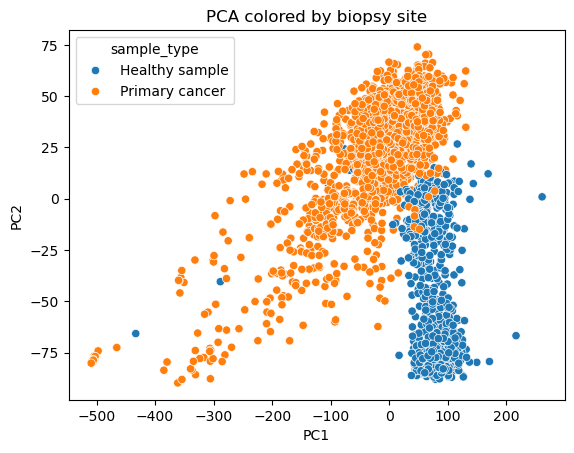

In [26]:

pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_log_tmm)

# Combine with clinical data
pca_df = pd.DataFrame(pca_result, columns=["PC1", "PC2"])
pca_df = pd.concat([pca_df, metadata_df.reset_index(drop=True)], axis=1)

sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="sample_type")
plt.title("PCA colored by biopsy site")
plt.show()


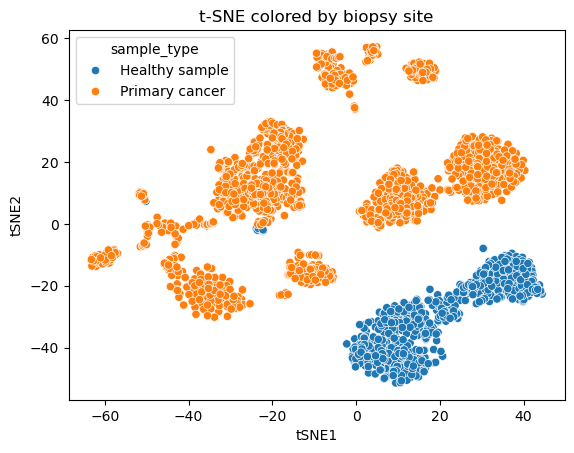

In [25]:

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(scaled_log_tmm)

tsne_df = pd.DataFrame(tsne_result, columns=["tSNE1", "tSNE2"])
tsne_df = pd.concat([tsne_df, metadata_df.reset_index(drop=True)], axis=1)

sns.scatterplot(data=tsne_df, x="tSNE1", y="tSNE2", hue="sample_type")
plt.title("t-SNE colored by biopsy site")
plt.show()


/home/fatouh/anaconda3/envs/crc_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


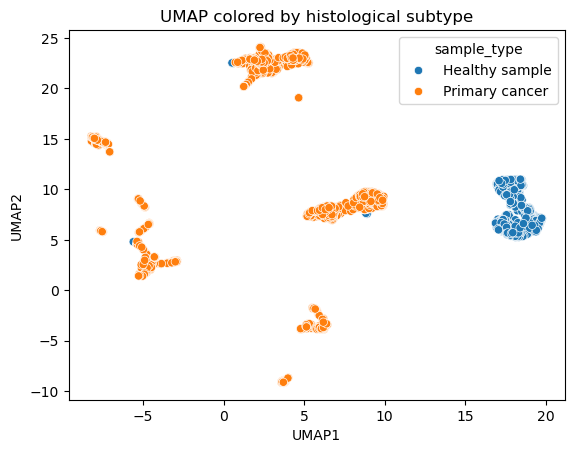

In [24]:

umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
umap_result = umap_model.fit_transform(scaled_log_tmm)

umap_df = pd.DataFrame(umap_result, columns=["UMAP1", "UMAP2"])
umap_df = pd.concat([umap_df, metadata_df.reset_index(drop=True)], axis=1)

sns.scatterplot(data=umap_df, x="UMAP1", y="UMAP2", hue="sample_type")
plt.title("UMAP colored by histological subtype")
plt.show()


/home/fatouh/anaconda3/envs/crc_env/lib/python3.12/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


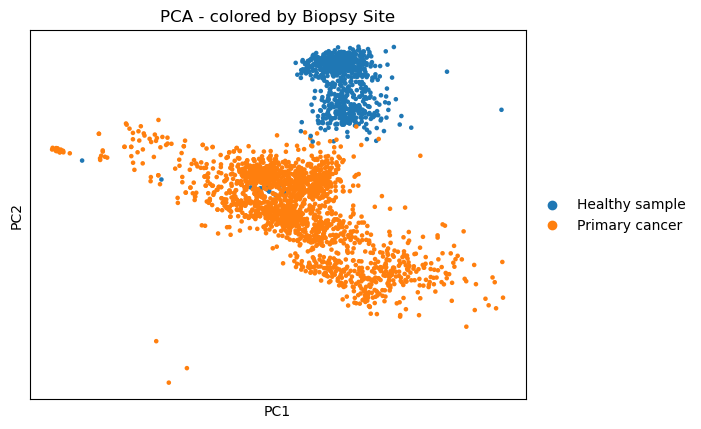

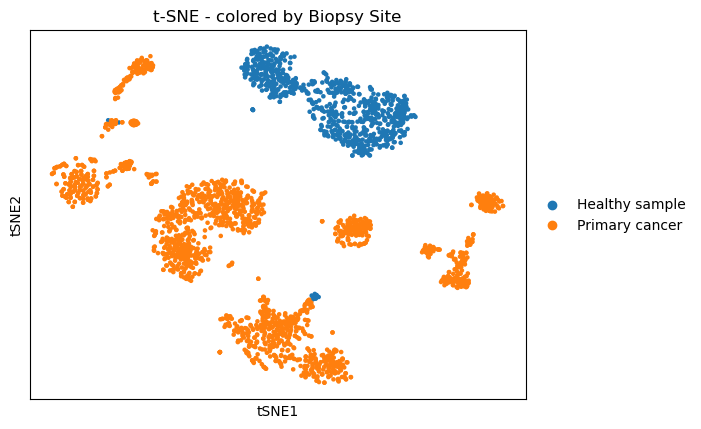

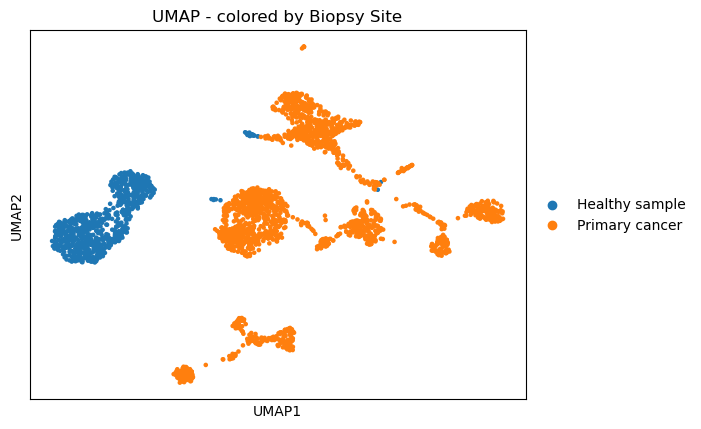

In [33]:
filtered_expr = filtered_expr.transpose()
adata = anndata.AnnData(filtered_expr)

# Add biopsy_site info as obs
adata.obs['sample_type'] = metadata_df.loc[filtered_expr.index, 'sample_type']

# Select Highly Variable Genes 
sc.pp.highly_variable_genes(adata, flavor='seurat', n_top_genes=2000)
adata = adata[:, adata.var['highly_variable']]

# Scale data (z-score genes)
sc.pp.scale(adata)

# PCA
sc.tl.pca(adata)

# t-SNE
sc.tl.tsne(adata, use_rep='X_pca')

# UMAP
sc.pp.neighbors(adata, use_rep='X_pca')
sc.tl.umap(adata)

# Plot PCA colored by sample_type
sc.pl.pca(adata, color='sample_type', title='PCA - colored by Biopsy Site')

# Plot t-SNE colored by sample_type
sc.pl.tsne(adata, color='sample_type', title='t-SNE - colored by Biopsy Site')

# Plot UMAP colored by sample_type
sc.pl.umap(adata, color='sample_type', title='UMAP - colored by Biopsy Site')